# RL Lab 8: REINFORCE

基于REINFORCE的小丑牌策略算法。

## 简介

和基于价值的DQN算法不同，REINFORCE是一种基于策略的方法，即模型直接输出动作分布作为策略，随后根据策略梯度定理优化该策略。相比于基于价值的算法无法应对连续的动作空间，基于动作的算法可以有效处理无限动作空间的情形。

$$
\nabla_\theta J(\theta) = \mathbb E_{s\sim \rho_\gamma^\pi, a\sim \pi(a\mid s; \theta)} \left[ Q^{\pi_\theta}(s, a) \nabla_\theta \log \pi(a\mid s; \theta) \right]
$$

REINFORCE使用蒙特卡洛方法生成完整的一个决策路径作为$Q^\pi (s, a)$用于更新策略。

## 目标

* 在`JimboEnvironment`环境中实现REINFORCE算法。
* 对比REINFORCE算法在有baseline和无baseline的情况下的收敛情况

### 拓展

* 如何避免REINFORCE算法的策略崩溃问题？
* 当$G_t$数值范围很大时，如何避免数值不稳定？

In [1]:
from typing import List, Generator, NamedTuple, Dict

from rl_jimbo_env import JimboState, JimboAction, JimboEnvironment

import torch
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'png'

每个决策路径包含$(s, a, r)$三元组，最终到达一个吸收状态$s_T$。在该任务中，我们所有的吸收状态全一致，并且决策步数也相同，所以无需考虑。

In [2]:
DecisionTriple = NamedTuple('DecisionTriple', [
    ('state', JimboState),
    ('action', JimboAction),
    ('reward', float)
])


def to_G_t(sequence: List[DecisionTriple], discount: float) -> List[DecisionTriple]:
    """
    Calculate the G_t value for a given sequence of decisions.
    """
    result = []
    for i in sequence[::-1]:
        if not result:
            result.append(i)
        else:
            result.append(DecisionTriple(
                state=i.state,
                action=i.action,
                reward=i.reward + discount * result[-1].reward
            ))
    return result

策略模型需要计算$\pi(a\mid s)$，状态为5张手牌，可以用transformer对手牌进行建模，之后将输出映射到动作空间上。动作为5个独立的二分类问题，表示是否弃掉该张牌。Baseline模型需要给定状态计算状态价值$V(s)$。

In [3]:
class PolicyModel(torch.nn.Module):
    def __init__(self, card_embed_dim: int = 16):
        super(PolicyModel, self).__init__()
        self.trmlayer = torch.nn.TransformerEncoderLayer(
            d_model=card_embed_dim,
            nhead=4,
            dim_feedforward=4 * card_embed_dim,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        # Main model
        self.trm = torch.nn.TransformerEncoder(
            self.trmlayer,
            num_layers=4
        )
        self.fc = torch.nn.Linear(card_embed_dim, 1)

    def forward(self, hold: torch.Tensor) -> torch.Tensor:
        # Hold shape: (batch_size, num_cards, card_embed_dim)
        return self.fc(self.trm(hold)).squeeze(-1) # (batch_size, num_cards)

class BaselineModel(torch.nn.Module):
    def __init__(self, card_embed_dim: int = 16):
        super(BaselineModel, self).__init__()
        self.trmlayer = torch.nn.TransformerEncoderLayer(
            d_model=card_embed_dim,
            nhead=4,
            dim_feedforward=4 * card_embed_dim,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        # Main model
        self.trm = torch.nn.TransformerEncoder(
            self.trmlayer,
            num_layers=4
        )
        self.fc = torch.nn.Linear(card_embed_dim * 5, 1)

    def forward(self, hold: torch.Tensor) -> torch.Tensor:
        # Hold shape: (batch_size, num_cards, card_embed_dim)
        return self.fc(self.trm(hold).reshape(hold.shape[0], -1)).squeeze(-1)

REINFORCE相当于对每个动作的概率计算负对数似然，然后按照奖励的大小进行加权。如果没有baseline，则是直接用累积奖励$G_t$作为权重，由于采样结果的方差可能很大，缺少baseline会导致训练不稳定。常用的做法是引入一个baseline模型$V_\phi(s)$，用来估计当前状态的价值。在更新中交替地更新策略模型的参数$\theta$和baseline模型的参数$\phi$。

In [4]:
class JimboREINFORCEAgent(torch.nn.Module):
    def __init__(
        self, card_embed_dim: int = 16, discount: float = 0.9,
        use_baseline: bool = False
    ):
        super(JimboREINFORCEAgent, self).__init__()
        self.card_embed = torch.nn.Embedding(53, card_embed_dim)
        self.discount = discount

        self.policy_model = PolicyModel(card_embed_dim)
        if use_baseline:
            self.baseline_model = BaselineModel(card_embed_dim)
        else:
            self.baseline_model = None
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.mse = torch.nn.MSELoss(reduction='none')

        self.device = 'cpu'


    def set_device(self, device: str):
        self.device = device
        self.to(device)

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        s = self.card_embed(s)
        return self.policy_model(s)

    def baseline_forward(self, s: torch.Tensor) -> torch.Tensor:
        if self.baseline_model is None:
            raise ValueError('The agent does not use a baseline model.')
        s = self.card_embed(s)
        return self.baseline_model(s)

    def policy_loss(self, triples: List[DecisionTriple]) -> torch.Tensor:
        '''
        Calculate the policy loss for a given sequence of decisions.
        '''
        # triples: {state: JimboState, action: JimboAction, reward: float}
        # Convert the triples to tensors
        G_t = to_G_t(triples, self.discount)
        states = self.states_to_tensor([t.state for t in G_t])
        actions = self.actions_to_tensor([t.action for t in G_t])
        Qs = torch.tensor([t.reward for t in G_t], dtype=torch.float, device=self.device)
        if self.baseline_model is None:
            Qs = Qs / 100
        else:
            # Shape: (batch_size, num_cards)
            Qs = Qs / 100 - self.baseline_forward(states).detach()
        # Calculate the policy loss
        policy_logits = self(states) # Shape: (batch_size, num_cards)
        policy_loss = self.bce(policy_logits, actions.float()).sum(dim=1)
        policy_loss = (policy_loss * Qs).mean()
        return policy_loss # Negative because we want to maximize the reward

    def baseline_loss(self, triples: List[DecisionTriple]) -> torch.Tensor:
        '''
        Calculate the baseline loss for a given sequence of decisions.
        '''
        # triples: {state: JimboState, action: JimboAction, reward: float}
        # Convert the triples to tensors
        G_t = to_G_t(triples, self.discount)
        states = self.states_to_tensor([t.state for t in G_t])
        Q_hats = self.baseline_forward(states)  # Shape: (batch_size)
        Qs = torch.tensor([t.reward for t in G_t], dtype=torch.float, device=self.device)
        # Calculate the baseline loss
        return self.mse(Q_hats, Qs / 100).mean() # Mean squared error

    def policy(self, states: List[JimboState]) -> List[JimboAction]:
        # Epsilon-greedy policy
        states_tensor = self.states_to_tensor(states)
        policy_prob = torch.sigmoid(self(states_tensor))
        # Sample actions from the policy
        actions = torch.bernoulli(policy_prob).long() # Shape: (batch_size, num_cards)
        return [JimboAction(tuple(row)) for row in actions.tolist()]

    def action_to_tensor(
        self, action: JimboAction
    ) -> torch.Tensor:
        # Convert the action to a tensor
        # action: 0-1 * 5
        return torch.tensor(action.discard, dtype=torch.long, device=self.device)

    def actions_to_tensor(
        self, actions: List[JimboAction]
    ) -> torch.Tensor:
        # Convert the actions to a tensor
        # actions: 0-1 * 5
        return torch.tensor([
            action.discard for action in actions
        ], dtype=torch.float, device=self.device)

    def state_to_tensor(
        self, states: JimboState
    ) -> torch.Tensor:
        # Convert the state to a tensor
        # state: {hold: card * 5, discard: card * 0-n, round: int}
        hold_idx_tensor = torch.tensor([
            card.index for card in states.hold
        ], dtype=torch.float, device=self.device)
        return hold_idx_tensor

    def states_to_tensor(self, states: List[JimboState]) -> torch.Tensor:
        # Convert the states to a tensor
        # states: {hold: card * 5, discard: card * 0-n, round: int}
        hold_idx_tensor = torch.tensor([
            [card.index for card in state.hold] for state in states
        ], dtype=torch.long, device=self.device)
        return hold_idx_tensor

训练过程中使用一组固定的初始状态用于评估训练效果。

In [5]:
env = JimboEnvironment()
agent_wo_baseline = JimboREINFORCEAgent(64, 0.9)
agent_wo_baseline.set_device('mps')

eval_states = [env.starting_state for _ in range(128)]

def simulate(
    env: JimboEnvironment, agent: JimboREINFORCEAgent, n: int = 512,
    states: List[JimboState] | None = None
) -> float:
    # Simulate the environment with the agent
    agent.eval()
    if states is None:
        states = [env.starting_state for _ in range(n)]
    states = states.copy()
    assert all(state.round == 0 for state in states), "states must be in round 0"
    while True:
        assert states is not None
        actions = agent.policy(states) # type: ignore
        states, rewards = zip(*(
            env.state_transition(state, action)
            for state, action in zip(states, actions)
        ))
        assert states is not None
        if any(state.round >= 2 for state in states):
            break
    agent.train()
    return sum(rewards) / len(rewards)


simulate(env, agent_wo_baseline, states=eval_states)

59.9296875

In [6]:
agent_baseline = JimboREINFORCEAgent(64, 0.9, use_baseline=True)
agent_baseline.set_device('mps')

simulate(env, agent_baseline, states=eval_states)

62.0546875

In [7]:
import itertools

def train(
    env: JimboEnvironment, agent: JimboREINFORCEAgent, *,
    batch_size: int = 128, lr: float = 1e-3, weight_decay: float = 1e-5,
    eval_steps: int = 10, eval_states: List[JimboState] | None = None,
    max_steps: int = 10000
) -> Generator[Dict[str, float | None], None, None]:
    use_baseline = agent.baseline_model is not None
    policy_optimizer = torch.optim.Adam(agent.parameters(), lr=lr, weight_decay=weight_decay)
    baseline_optimizer = torch.optim.Adam(agent.parameters(), lr=lr, weight_decay=weight_decay)
    for step in range(max_steps):
        states = [env.starting_state for _ in range(batch_size)]
        trajectories: List[List[DecisionTriple]] = [[] for _ in range(batch_size)]

        for i in range(2):
            actions = agent.policy(states)
            next_states = []

            for i, (state, action) in enumerate(zip(states, actions)):
                next_state, reward = env.state_transition(state, action)
                next_states.append(next_state)
                trajectories[i].append(
                    DecisionTriple(state, action, reward)
                )

            # Update the states
            states = next_states

        # Calculate the policy loss
        triples = [*itertools.chain.from_iterable(trajectories)]
        policy_loss = agent.policy_loss(triples)
        metrics: Dict[str, float | None] = {'policy': policy_loss.item()}

        policy_optimizer.zero_grad()
        policy_loss.backward()
        baseline_optimizer.step()

        if use_baseline:
            baseline_loss = agent.baseline_loss(triples)
            metrics['baseline'] = baseline_loss.item()

            baseline_optimizer.zero_grad()
            baseline_loss.backward()
            baseline_optimizer.step()
        else:
            metrics['baseline'] = None

        if step % eval_steps == 0:
            metrics['reward'] = simulate(env, agent, states=eval_states)
        else:
            metrics['reward'] = None

        yield metrics

        states = [state for state in next_states if state.round < 2]
        states.extend([
            env.starting_state for _ in range(batch_size // 2)
        ])

训练模型并绘制Q损失和平均奖励曲线。

In [8]:
from IPython.display import clear_output
import math

def append_ma(
    data: List[float], new_data: float, alpha: float = 0.99
):
    if not data:
        data.append(new_data)
    else:
        data.append(data[-1] * alpha + (1 - alpha) * new_data)

def plot_train(
    train_gen: Generator[Dict[str, float | None], None, None],
    plot_steps: int = 100, max_steps: int = 10000, alpha: float = 0.99
):
    metrics = {}
    plt.ion()
    for step, metric in enumerate(train_gen):
        if step >= max_steps:
            break

        for k, v in metric.items():
            if k not in metrics:
                metrics[k] = []
            if v is not None:
                append_ma(metrics[k], v, alpha)

        if step % plot_steps == 0:
            clear_output(wait=True)
            fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, dpi=300)

            xlim_step = max_steps / 10

            policy_loss, baseline_loss = metrics['policy'], metrics['baseline']
            reward = metrics['reward']

            limit = math.ceil(len(policy_loss) / xlim_step) * xlim_step
            len_ratio = len(policy_loss) / len(reward)

            ax0.clear()
            ax0.plot(policy_loss, label='Policy Loss')
            if baseline_loss:
                ax0.plot(baseline_loss, label='Baseline Loss')
                ax0.legend()
            ax0.set_title("Loss")
            ax0.set_xlabel("Step")
            ax0.set_ylabel("Loss")
            ax0.set_xlim(0, limit)
            ax0.grid()

            ax1.clear()
            ax1.plot(
                [i * len_ratio for i, _ in enumerate(reward)],
                reward
            )
            ax1.set_title("Episodic Rewards")
            ax1.set_xlabel("Step")
            ax1.set_ylabel("Reward")
            ax1.set_xlim(0, limit)
            ax1.grid()

            plt.draw()
            plt.pause(0.01)

没有baseline的REINFORCE算法的收敛速度较慢，且容易出现策略崩溃的问题。

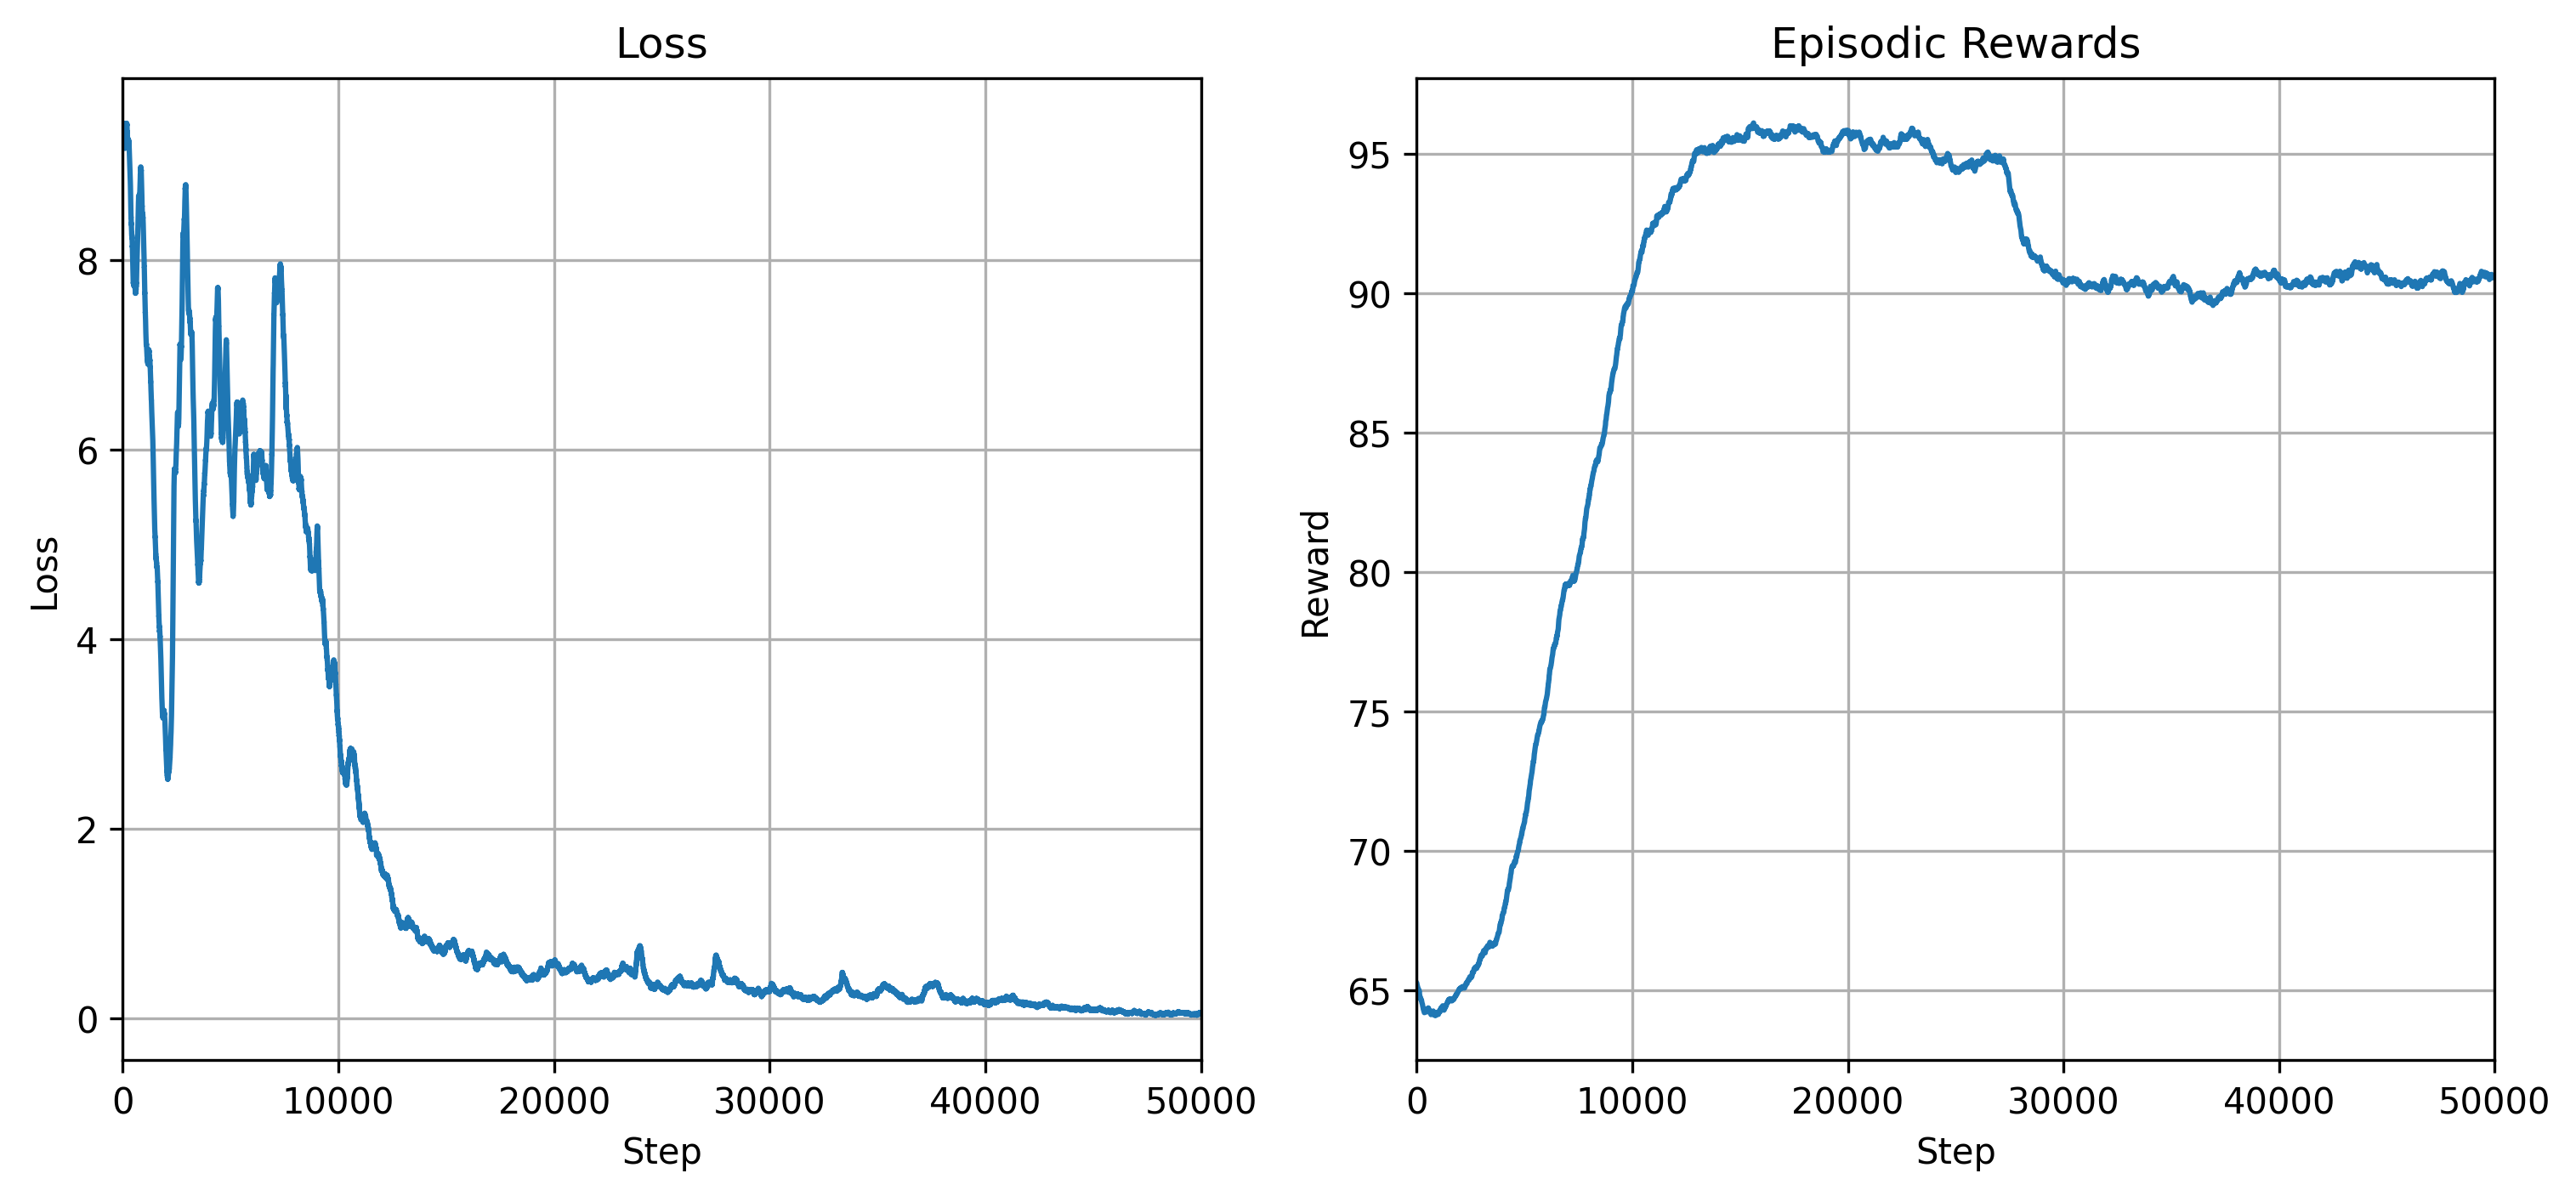

In [9]:
train_args = {
    'batch_size': 64,
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'eval_steps': 10,
    'max_steps': 50000
}

train_gen = train(env, agent_wo_baseline, eval_states=eval_states, **train_args)
plot_train(train_gen, plot_steps=50, max_steps=50000, alpha=0.99)

引入baseline后，REINFORCE算法的收敛速度明显加快，且在出现策略崩溃后模型能够逐渐恢复。

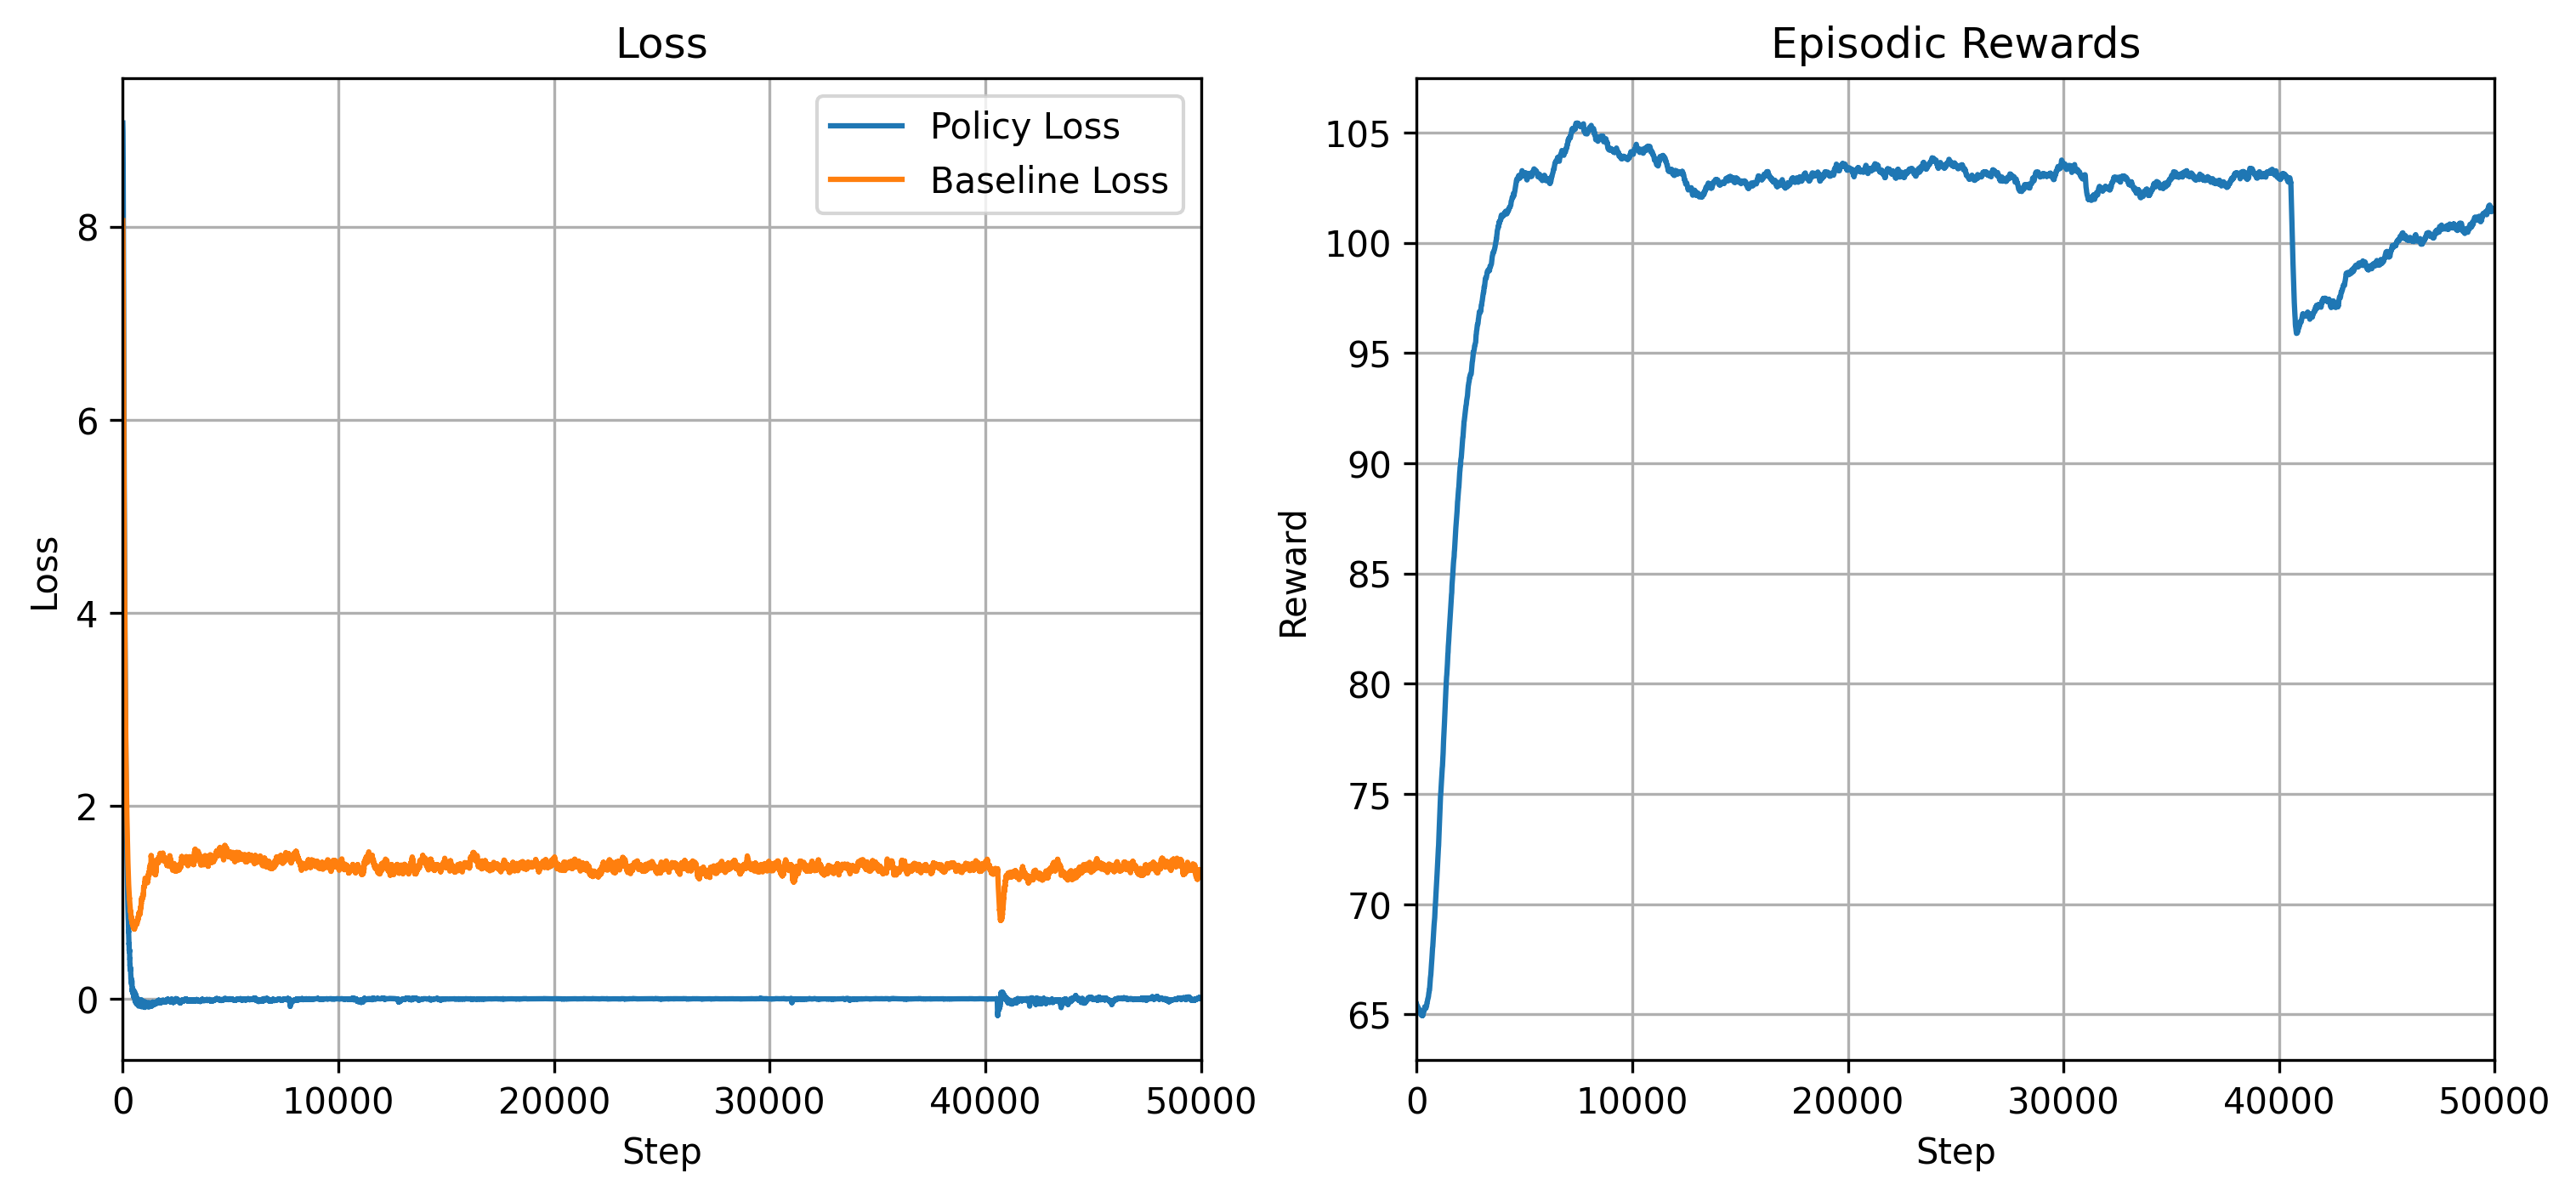

In [10]:
train_args = {
    'batch_size': 64,
    'lr': 1e-4,
    'weight_decay': 1e-5,
    'eval_steps': 10,
    'max_steps': 50000
}

train_gen = train(env, agent_baseline, eval_states=eval_states, **train_args)
plot_train(train_gen, plot_steps=50, max_steps=50000, alpha=0.99)

训练结束后对比训练前后智能体的表现，并且展示一组智能体的策略。

In [11]:
simulate(env, agent_wo_baseline, states=eval_states)

96.5234375

In [12]:
simulate(env, agent_baseline, states=eval_states)

100.7578125

In [13]:
import random

states_eval = eval_states.copy()
agent_wo_baseline.eval()
idx = random.randint(0, len(states_eval) - 1)

while True:
    print(states_eval[idx])
    actions = agent_wo_baseline.policy(states_eval)  # type: ignore
    print(actions[idx])
    states_eval, rewards = zip(*(
        env.state_transition(state, action)
        for state, action in zip(states_eval, actions)
    ))
    print(states_eval[idx])
    if any(state.round >= 2 for state in states_eval):
        break
print(states_eval[idx].ratio)
print(rewards[idx])

6♣ 9♦ K♦ Q♦ 3♠
JimboAction(discard=(0, 0, 0, 0, 1))
6♣ 9♦ K♦ Q♦ 3♣
6♣ 9♦ K♦ Q♦ 3♣
JimboAction(discard=(0, 0, 0, 0, 1))
6♣ 9♦ K♦ Q♦ J♥
1
51


In [14]:
states_eval = eval_states.copy()
agent_baseline.eval()
idx = random.randint(0, len(states_eval) - 1)

while True:
    print(states_eval[idx])
    actions = agent_baseline.policy(states_eval)  # type: ignore
    print(actions[idx])
    states_eval, rewards = zip(*(
        env.state_transition(state, action)
        for state, action in zip(states_eval, actions)
    ))
    print(states_eval[idx])
    if any(state.round >= 2 for state in states_eval):
        break
print(states_eval[idx].ratio)
print(rewards[idx])

7♣ 6♣ 5♣ 2♥ 4♦
JimboAction(discard=(1, 1, 1, 1, 1))
2♦ 2♣ 3♠ Q♣ Q♦
2♦ 2♣ 3♠ Q♣ Q♦
JimboAction(discard=(1, 1, 1, 0, 1))
9♦ 10♦ 6♥ Q♣ J♠
1
48
